# LHIPA with blinks, no stitch

### check stimuli LHIPA for first visit

### input file
* gs_local_gazeWithBlink_pupil_aoi.csv (valid gaze data with blink data)

### output file

In [2]:
import pandas as pd
import numpy as np
import math, pywt
import matplotlib.pyplot as plt

In [2]:
def modmax(d): 
    # compute signal modulus 
    m = [0.0]*len(d) 
    for i in range(len(d)): 
        m[i] = math.fabs(d[i]) 
        
    # if value is larger than both neighbours , and strictly 
    # larger than either, then it is a local maximum 
    t = [0.0]*len(d) 
    for i in range(len(d)): 
        ll = m[i-1] if i >= 1 else m[i] 
        oo = m[i] 
        rr = m[i+1] if i < len(d)-2 else m[i] 
        if (ll <= oo and oo >= rr) and (ll < oo or oo > rr): 
            # compute magnitude 
            t[i] = math.sqrt(d[i]**2) 
        else: 
            t[i] = 0.0 
            
    return t

In [3]:
def lhipa_new(d):
    # find max decomposition level
    w = pywt.Wavelet('sym16')
    maxlevel = pywt.dwt_max_level(len(d[0]),filter_len=w.dec_len)
    # print(maxlevel)
    
    # set high and low frequency band indeces
    hif, lof = 1, int(maxlevel/2)
    
    # get detail coefficients of pupil diameter signal d
    cD_H = pywt.downcoef('d', d[0], 'sym16', 'per', level = hif)
    cD_L = pywt.downcoef('d', d[0], 'sym16', 'per', level = lof)
    
    # normalize by 1/root(2^(j))
    cD_H[:] = [x / math.sqrt(2**hif) for x in cD_H]
    cD_L[:] = [x / math.sqrt(2**lof) for x in cD_L]
    
    # obtain the LH:HF ratio
    cD_LH = cD_L
    for i in range(len(cD_L)):
        cD_LH[i] = cD_L[i] / cD_H[((2**lof)//(2**hif))*i]
        
    # detect modulus maxima, see Duchowski et al.
    cD_LHm = modmax(cD_LH)
    
    # threshold using universal threshold λuniv = σˆ (2 log n)
    # where σˆ is the standard deviation of the noise
    λuniv = np.std(cD_LHm) * math.sqrt(2.0*np.log2(len(cD_LHm))) 
    cD_LHt = pywt.threshold(cD_LHm, λuniv, mode ="less")
    
    # get signal duration (in seconds)
    tt = (d[1][-1] - d[1][0]) / 1000
    
    # compute LHIPA
    ctr = 0
    for i in range(len(cD_LHt)):
        if math.fabs(cD_LHt[i]) > 0: ctr += 1
    LHIPA = float(ctr)/tt
    
    return LHIPA

In [3]:
gaze_df = pd.read_csv('/Volumes/Extreme SSD/research data/good system/database tables/gs_local_gazeWithBlink_pupil_aoi.csv')
gaze_df.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Blink_detected,ET_PupilLeft,ET_PupilRight,ET_ValidityLeft,ET_ValidityRight,Fixation Index
0,1628616621280,P001,A2002,fc_row_5_src_rep,NaN,3.515396,3.655457,0,0,2858.0
1,1628616621284,P001,A2002,fc_row_5_src_rep,0.0,3.511688,3.648514,0,0,2858.0
2,1628616621287,P001,A2002,fc_row_5_src_rep,0.0,3.507050,3.617889,0,0,2858.0
3,1628616621290,P001,A2002,fc_row_5_src_rep,NaN,3.514343,3.643295,0,0,2858.0
4,1628616621294,P001,A2002,fc_row_5_src_rep,0.0,3.525589,3.646912,0,0,2858.0


In [4]:
gaze_df.shape[0]

6252567

In [7]:
gaze_df[gaze_df['user_id']=='P024'].shape

(0, 11)

In [5]:
gaze_df['ET_pupilAvg']=0
gaze_df.loc[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==0),['ET_pupilAvg']] = \
(gaze_df[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==0)]['ET_PupilLeft']+gaze_df[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==0)]['ET_PupilRight'])/2
gaze_df.loc[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==4),['ET_pupilAvg']] = \
gaze_df[(gaze_df['ET_ValidityLeft']==0) & (gaze_df['ET_ValidityRight']==4)]['ET_PupilLeft']
gaze_df.loc[(gaze_df['ET_ValidityLeft']==4) & (gaze_df['ET_ValidityRight']==0),['ET_pupilAvg']] = \
gaze_df[(gaze_df['ET_ValidityLeft']==4) & (gaze_df['ET_ValidityRight']==0)]['ET_PupilRight']

In [6]:
gaze_df.shape

(6252567, 11)

In [10]:
gaze_df.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Blink_detected,ET_PupilLeft,ET_PupilRight,ET_ValidityLeft,ET_ValidityRight,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,NaN,3.515396,3.655457,0,0,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,0.0,3.511688,3.648514,0,0,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,0.0,3.507050,3.617889,0,0,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,NaN,3.514343,3.643295,0,0,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,0.0,3.525589,3.646912,0,0,2858.0,3.586250


In [11]:
df_fix = pd.read_csv('/Volumes/Extreme SSD/research data/good system/database tables/gs_data_ET_fixation_label.csv')
df_fix.head()

,userid,claim_id,ui,imotion_unix_timestamp,fixation_index,fixation_x,fixation_y,fixation_duration,AOI
0,P001,2002,A,1628616621280,2858,508.008642,650.866667,1349.81770,fc_row_5_src_rep
1,P001,2002,A,1628616621674,2859,215.234694,201.908163,163.35375,fc_heading_src_name
2,P001,2002,A,1628616621890,2860,187.616426,144.592558,203.31450,header_txt
3,P001,2002,A,1628616622147,2861,350.763158,250.618421,126.65200,fc_row_1_src_rep
4,P001,2002,A,1628616622307,2862,476.639299,240.383130,309.95885,fc_row_1_src_rep


In [12]:
gaze_aoi_selected = gaze_df.loc[:,['imotion_unix_timestamp','user_id','SourceStimuliName','gaze_AOI','Fixation Index','ET_pupilAvg']]
gaze_aoi_selected.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250


### stimuli LHIPA (only first visits)

In [30]:
visit_ts = pd.read_csv('/Volumes/Extreme SSD/research data/good system/database tables/news_visited_ts.csv')
visit_ts.head()

,userid,claim_id,ui,news_visits_startts,news_visits_endts
0,P001,2002,A,1628616651702,1628616686647
1,P001,2002,A,1628616688343,1628616749773
2,P001,2002,A,1628616752423,1628616801523
3,P001,2011,A,1628616896935,1628616958264
4,P001,2006,A,1628617114904,1628617133233


In [31]:
gaze_aoi_selected = gaze_aoi_selected.sort_values('imotion_unix_timestamp')
gaze_aoi_selected.head()

,imotion_unix_timestamp,user_id,SourceStimuliName,gaze_AOI,Fixation Index,ET_pupilAvg
0,1628616621280,P001,A2002,fc_row_5_src_rep,2858.0,3.585426
1,1628616621284,P001,A2002,fc_row_5_src_rep,2858.0,3.580101
2,1628616621287,P001,A2002,fc_row_5_src_rep,2858.0,3.562469
3,1628616621290,P001,A2002,fc_row_5_src_rep,2858.0,3.578819
4,1628616621294,P001,A2002,fc_row_5_src_rep,2858.0,3.586250


In [33]:
visit_ts = visit_ts.sort_values('news_visits_startts')
first_visit_ts = visit_ts.drop_duplicates(subset=['userid','claim_id'], keep='first')
first_visit_ts.head()

,userid,claim_id,ui,news_visits_startts,news_visits_endts
0,P001,2002,A,1628616651702,1628616686647
3,P001,2011,A,1628616896935,1628616958264
4,P001,2006,A,1628617114904,1628617133233
7,P001,2012,A,1628617477493,1628617490573
9,P001,1009,A,1628617599257,1628617633674


In [40]:
# calculate first stimuli visit LHIPA per claim per user
stimuli_ipa_df = pd.DataFrame(columns=['userid','claim_id','start_ts','end_ts','LHIPA','gaze_cnt'])
count=1

for index,row in first_visit_ts.iterrows():
    userid = row['userid']
    claim_id = row['ui']+str(row['claim_id'])
    # print(claim_id)
    st_ts = row['news_visits_startts']
    
    first_visit_gaze = gaze_aoi_selected[(gaze_aoi_selected['user_id']==userid)&\
                                         (gaze_aoi_selected['SourceStimuliName']==claim_id)&\
                                         (gaze_aoi_selected['imotion_unix_timestamp']<=st_ts)]
    
    # print(first_visit_gaze.shape)
    pupil_list = first_visit_gaze['ET_pupilAvg'].tolist()
    # print(len(pupil_list), ", list is:", pupil_list)
    ts_list = first_visit_gaze['imotion_unix_timestamp'].tolist()
    
    # judge if need to calculate LHIPA (count>125)
    if len(pupil_list)>125:
        lhipa_list = [pupil_list, ts_list]
        lhipa = lhipa_new(lhipa_list)

        new_row = {'userid': userid, 'claim_id': claim_id, 'start_ts': st_ts, 
                   'end_ts': end_ts, 'LHIPA': lhipa, 'gaze_cnt': len(pupil_list)}
        stimuli_ipa_df = stimuli_ipa_df.append(new_row, ignore_index=True)
    
    if count%10==0: print(f"Processing the {count} stimuli...")
    count = count+1

Processing the 10 stimuli...
Processing the 20 stimuli...
Processing the 30 stimuli...
Processing the 40 stimuli...
Processing the 50 stimuli...
Processing the 60 stimuli...
Processing the 70 stimuli...
Processing the 80 stimuli...
Processing the 90 stimuli...
Processing the 100 stimuli...
Processing the 110 stimuli...
Processing the 120 stimuli...
Processing the 130 stimuli...
Processing the 140 stimuli...
Processing the 150 stimuli...
Processing the 160 stimuli...
Processing the 170 stimuli...
Processing the 180 stimuli...
Processing the 190 stimuli...
Processing the 200 stimuli...
Processing the 210 stimuli...
Processing the 220 stimuli...
Processing the 230 stimuli...
Processing the 240 stimuli...
Processing the 250 stimuli...
Processing the 260 stimuli...
Processing the 270 stimuli...
Processing the 280 stimuli...
Processing the 290 stimuli...
Processing the 300 stimuli...
Processing the 310 stimuli...
Processing the 320 stimuli...
Processing the 330 stimuli...
Processing the 340 

In [41]:
stimuli_ipa_df.head()

,userid,claim_id,start_ts,end_ts,LHIPA,gaze_cnt
0,P001,A2002,1628616651702,1628617991890,5.818540,8979
1,P001,A2011,1628616896935,1628617991890,12.501421,2610
2,P001,A2006,1628617114904,1628617991890,5.732328,9553
3,P001,A2012,1628617477493,1628617991890,11.518968,3780
4,P001,A1009,1628617599257,1628617991890,12.281836,3164


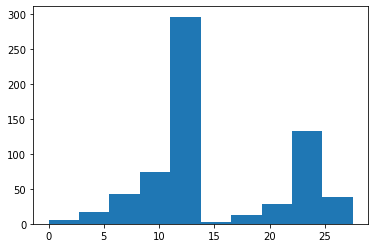

In [42]:
# plt.hist(ipa_df[ipa_df['LHIPA']>15]['gaze_cnt'])
plt.hist(stimuli_ipa_df['LHIPA'])
plt.show()

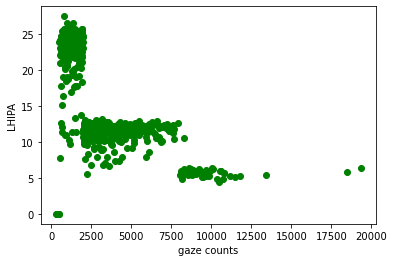

In [44]:
plt.scatter(stimuli_ipa_df['gaze_cnt'], stimuli_ipa_df['LHIPA'], c ="green")
plt.xlabel("gaze counts") #x label
plt.ylabel("LHIPA") #y label
plt.show()

In [45]:
stimuli_ipa_df['ui'] = ''
for index, row in stimuli_ipa_df.iterrows():
    # print(index)
    stimuli_ipa_df.iloc[index, 6] = row['claim_id'][0]
stimuli_ipa_df.head(5)

,userid,claim_id,start_ts,end_ts,LHIPA,gaze_cnt,ui
0,P001,A2002,1628616651702,1628617991890,5.818540,8979,A
1,P001,A2011,1628616896935,1628617991890,12.501421,2610,A
2,P001,A2006,1628617114904,1628617991890,5.732328,9553,A
3,P001,A2012,1628617477493,1628617991890,11.518968,3780,A
4,P001,A1009,1628617599257,1628617991890,12.281836,3164,A


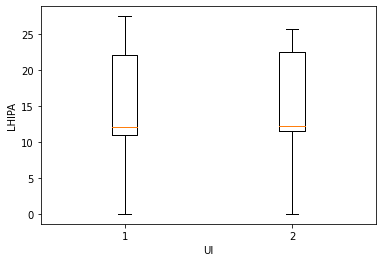

In [46]:
plt.boxplot([stimuli_ipa_df[stimuli_ipa_df['ui']=='A']['LHIPA'], stimuli_ipa_df[stimuli_ipa_df['ui']=='B']['LHIPA']])
plt.xlabel("UI") #x label
plt.ylabel("LHIPA") #y label
plt.show()

In [47]:
claim_info = pd.read_csv('/Users/lishi/Documents/research/Good System/data/claim.csv')
claim_info.head()

,userid,claim_id,AOI_string,valid_AOI_string,ui,st_time,end_time,fixation_duration_mean,fixation_duration_std,total_dwell_time,interface_use_time,news_reading_time,MWlevel,correctness
0,P001,2002,REXRHRHAEARHARSRSRSRCRSRSRSRHRHAHRHRCHRHCBCBR,RHRHARHARSRSRSRCRSRSRSRHRHAHRHRCHRHCR,A,1628616621315,1628616803087,248.892463,156.389441,181772,36297,145475,high,mix
1,P001,2011,XRCRHRHAHRHBCR,CRHRHAHRHCR,A,1628616888166,1628616960242,222.369650,95.347616,72076,10747,61329,high,false
2,P001,2006,XRHRHARSRHAHRHARHRHRHBCRSRSRHRHARHRHARCBCB,HRHARSRHAHRHARHRHRHCRSRSRHRHARHRHARC,A,1628617082318,1628617285093,223.236489,92.632922,202775,43600,159175,high,false
3,P001,2012,CXERHRAEARSRHRCRHRHACBHRHRHRHRSCBCBCR,CRHRARSRHRCRHRHACHRHRHRHRSCR,A,1628617464518,1628617524191,238.026256,117.681359,59673,28356,31317,high,false
4,P001,1009,RERHACRHRHRHSRHBR,RHACRHRHRHSRHR,A,1628617588465,1628617636889,226.276773,96.029932,48424,14007,34417,high,true


In [48]:
claim_MW = claim_info[['userid','claim_id','MWlevel']].copy()
claim_MW.head()

,userid,claim_id,MWlevel
0,P001,2002,high
1,P001,2011,high
2,P001,2006,high
3,P001,2012,high
4,P001,1009,high


In [50]:
stimuli_ipa_df['claim_num'] = ''
for index, row in stimuli_ipa_df.iterrows():
    stimuli_ipa_df.iloc[index, -1] = row['claim_id'][1:]
stimuli_ipa_df.head(5)

,userid,claim_id,start_ts,end_ts,LHIPA,gaze_cnt,ui,claim_num
0,P001,A2002,1628616651702,1628617991890,5.818540,8979,A,2002
1,P001,A2011,1628616896935,1628617991890,12.501421,2610,A,2011
2,P001,A2006,1628617114904,1628617991890,5.732328,9553,A,2006
3,P001,A2012,1628617477493,1628617991890,11.518968,3780,A,2012
4,P001,A1009,1628617599257,1628617991890,12.281836,3164,A,1009


In [51]:
stimuli_ipa_df['claim_num'] = pd.to_numeric(stimuli_ipa_df['claim_num'])
stimuli_ipa_df.head()

,userid,claim_id,start_ts,end_ts,LHIPA,gaze_cnt,ui,claim_num
0,P001,A2002,1628616651702,1628617991890,5.818540,8979,A,2002
1,P001,A2011,1628616896935,1628617991890,12.501421,2610,A,2011
2,P001,A2006,1628617114904,1628617991890,5.732328,9553,A,2006
3,P001,A2012,1628617477493,1628617991890,11.518968,3780,A,2012
4,P001,A1009,1628617599257,1628617991890,12.281836,3164,A,1009


In [53]:
ipa_df_cl2 = stimuli_ipa_df.merge(claim_MW, left_on=['userid','claim_num'], right_on=['userid','claim_id'], how='left')
ipa_df_cl2.head()

,userid,claim_id_x,start_ts,end_ts,LHIPA,gaze_cnt,ui,claim_num,claim_id_y,MWlevel
0,P001,A2002,1628616651702,1628617991890,5.818540,8979,A,2002,2002.0,high
1,P001,A2011,1628616896935,1628617991890,12.501421,2610,A,2011,2011.0,high
2,P001,A2006,1628617114904,1628617991890,5.732328,9553,A,2006,2006.0,high
3,P001,A2012,1628617477493,1628617991890,11.518968,3780,A,2012,2012.0,high
4,P001,A1009,1628617599257,1628617991890,12.281836,3164,A,1009,1009.0,high


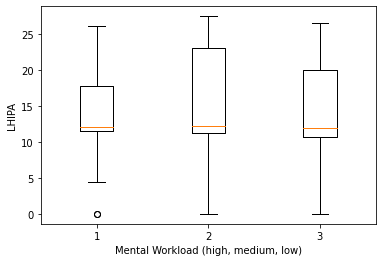

In [54]:
plt.boxplot([ipa_df_cl2[ipa_df_cl2['MWlevel']=='high']['LHIPA'],ipa_df_cl2[ipa_df_cl2['MWlevel']=='medium']['LHIPA'],\
             ipa_df_cl2[ipa_df_cl2['MWlevel']=='low']['LHIPA']])
plt.ylabel("LHIPA") #y label
plt.xlabel("Mental Workload (high, medium, low)")
plt.show()